<font size = "6"> Fordham Sports Analytics Society Big Data Bowl 2023 - Exploratory Analysis </font>

<font size = "4"> Run through ideas for eventual model, create new model features, and understand provided materials. </font>

- Authors:  Peter Majors, Chris Orlando, Jack Townsend, and Etienne Busnel
- Kaggle:  https://www.kaggle.com/competitions/nfl-big-data-bowl-2023/overview (Resources)
- Our Github:  https://github.com/peterlmajors/FSAS_BigDataBowl_2023 (Up-To-Date Code)

In [135]:
#Import Required Packages

#Data Manipulation
import pandas as pd
import numpy as np
import math

#Data Vizualization
import seaborn as sns 
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from haversine import haversine
from scipy.stats import pearsonr, spearmanr

#Notebook Settings
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [136]:
#Importing Kaggle Data (Needed For Animated Plays Function (Takes Original Data))

# #Games - Basic Information On All Games
games = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/games.csv")

# #pffScout - PFF Judgements For Each Player On Each Play
pffScout = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/pffScoutingData.csv")

# #Players - Basics On Players
players = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/players.csv")

# #Plays - Everthing About Specific Plays
plays = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/plays.csv")

# #Week - Frame-By-Frame Player Tracking
week1 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week1.csv")
week2 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week2.csv")
week3 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week3.csv")
week4 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week4.csv")
week5 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week5.csv")
week6 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week6.csv")
week7 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week7.csv")
week8 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/case_data/week8.csv")

In [137]:
#Define Function To Animate Plays
colors = {'ARI':"#97233F", 'ATL':"#A71930", 'BAL':'#241773', 'BUF':"#00338D", 'CAR':"#0085CA", 'CHI':"#C83803", 'CIN':"#FB4F14", 'CLE':"#311D00", 
          'DAL':'#003594', 'DEN':"#FB4F14", 'DET':"#0076B6", 'GB':"#203731", 'HOU':"#03202F", 'IND':"#002C5F", 'JAX':"#9F792C", 'KC':"#E31837", 
          'LA':"#003594", 'LAC':"#0080C6", 'LV':"#000000", 'MIA':"#008E97", 'MIN':"#4F2683", 'NE':"#002244", 'NO':"#D3BC8D", 'NYG':"#0B2265", 
          'NYJ':"#125740", 'PHI':"#004C54", 'PIT':"#FFB612", 'SEA':"#69BE28", 'SF':"#AA0000", 'TB':'#D50A0A', 'TEN':"#4B92DB", 'WAS':"#5A1414", 
          'football':'#CBB67C'}

def animate_play(tracking_df, play_df,players,pffScoutingData, gameId,playId):
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
             "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Plot Players
        for team in selected_tracking_df.team.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.team==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Position:{}<br>Role:{}".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0],
                                                                                      selected_player_df["pff_positionLinedUp"].values[0],
                                                                                      selected_player_df["pff_role"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

    return fig

In [138]:
#Import Our Merged DataFrames
# ptrack = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/ptrack.csv") #Player Tracking
ptrack_qb_poss = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/ptrack_qb_poss.csv") #Player Tracking Only On Frames Where QB The Target For Pass Rushers
# pbp = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/pbp.csv") #Play-By-Play Data
# pff_qb_pressure = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/pff_qb_pressure.csv") #Import PFF Data On QB Pressures

<font size="5">Check Out Individual Plays</font>

In [142]:
#Choose A Game and Play
gameId = 2021090900
playId = 97

#Run Animate Plays Function (Must Input Correct Week)
animate_play(week1, plays, players, pffScout, gameId, playId)

In [107]:
#Print Out All Frames From A Player and Play
player_in_play = ptrack.loc[(ptrack['gameId'] == gameId) & (ptrack['playId'] == playId)]['nflId'].reset_index().loc[0, 'nflId']
ptrack.loc[(ptrack['gameId'] == gameId) & (ptrack['nflId'] == 52421) & (ptrack['playId'] == playId)].sort_values(by = 'frameId', ascending = True)

#Print Out All Frames From Selected Game
#ptrack.loc[(ptrack['gameId'] == gameId) & (ptrack['playId'] == playId) & (ptrack['nflId'] == 53440)]

#Print Out All Plays From Selected Game
#ptrack.loc[(ptrack.gameId == gameId) & (ptrack.playDirection == 'right')]['playId'].sort_values().unique()

#Print Out All pbp Data From Selected Play
#pbp[(pbp['gameId'] == gameId) & (pbp['playId'] == playId)]


,Unnamed: 0,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,height,weight,birthDate,collegeName,officialPosition,displayName,x_qb,y_qb,s_qb,a_qb,dis_qb,o_qb,dir_qb,dist_from_qb,angle_to_qb,angle_to_qb_diff_o,nflId_blocker_x,nflId_rusher_x,displayName_rusher_x,pff_positionLinedUp_rusher_x,x_rusher_x,y_rusher_x,s_rusher_x,a_rusher_x,dis_rusher_x,o_rusher_x,dir_rusher_x,rusher_in_imm_box_x,blocker_rusher_distance_x,diff_btw_rusher_dir_blocker_o_x,bl_im_x_x,bl_im_y_x,br_im_x_x,br_im_y_x,fl_im_x_x,fl_im_y_x,fr_im_x_x,fr_im_y_x,nflId_blocker_y,nflId_rusher_y,displayName_rusher_y,pff_positionLinedUp_rusher_y,x_rusher_y,y_rusher_y,s_rusher_y,a_rusher_y,dis_rusher_y,o_rusher_y,dir_rusher_y,rusher_in_imm_box_y,blocker_rusher_distance_y,diff_btw_rusher_dir_blocker_o_y,bl_im_x_y,bl_im_y_y,br_im_x_y,br_im_y_y,fl_im_x_y,fl_im_y_y,fr_im_x_y,fr_im_y_y
235429,235429,2021103111,1063,52421,Pass Block,RT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37097.0,PA,0.0,1,2021-10-31T21:05:45.000,78.0,TB,left,55.07,27.12,0.00,0.00,0.01,260.76,10.07,None,6-5,322,1999-01-24,Iowa,T,Tristan Wirfs,55.44,23.70,0.00,0.00,0.00,267.87,281.88,3.439956,0.67,260.09,52421.0,37097.0,Cameron Jordan,LOLB,53.14,28.73,0.00,0.00,0.00,140.10,123.29,False,2.51,317.47,55.19,26.38,54.95,27.86,54.01,26.19,53.77,27.67,52421.0,37097.0,Cameron Jordan,LOLB,53.14,28.73,0.00,0.00,0.00,140.10,123.29,False,2.51,317.47,55.19,26.38,54.95,27.86,54.20,26.22,53.96,27.70
235451,235451,2021103111,1063,52421,Pass Block,RT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37097.0,PA,0.0,2,2021-10-31T21:05:45.100,78.0,TB,left,55.07,27.12,0.00,0.00,0.00,260.76,11.16,None,6-5,322,1999-01-24,Iowa,T,Tristan Wirfs,55.44,23.71,0.00,0.00,0.00,267.87,284.13,3.430015,0.67,260.09,52421.0,37097.0,Cameron Jordan,LOLB,53.14,28.72,0.00,0.00,0.00,140.10,124.83,False,2.51,315.93,55.19,26.38,54.95,27.86,54.01,26.19,53.77,27.67,52421.0,37097.0,Cameron Jordan,LOLB,53.14,28.72,0.00,0.00,0.00,140.10,124.83,False,2.51,315.93,55.19,26.38,54.95,27.86,54.20,26.22,53.96,27.70
235473,235473,2021103111,1063,52421,Pass Block,RT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37097.0,PA,0.0,3,2021-10-31T21:05:45.200,78.0,TB,left,55.07,27.12,0.00,0.00,0.00,260.76,15.19,None,6-5,322,1999-01-24,Iowa,T,Tristan Wirfs,55.44,23.72,0.00,0.00,0.01,267.87,288.92,3.420073,0.68,260.08,52421.0,37097.0,Cameron Jordan,LOLB,53.13,28.72,0.00,0.00,0.01,140.10,129.40,False,2.51,311.36,55.19,26.38,54.95,27.86,54.01,26.19,53.77,27.67,52421.0,37097.0,Cameron Jordan,LOLB,53.13,28.72,0.00,0.00,0.01,140.10,129.40,False,2.51,311.36,55.19,26.38,54.95,27.86,54.20,26.22,53.96,27.70
235495,235495,2021103111,1063,52421,Pass Block,RT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37097.0,PA,0.0,4,2021-10-31T21:05:45.300,78.0,TB,left,55.07,27.12,0.00,0.00,0.00,260.76,15.37,None,6-5,322,1999-01-24,Iowa,T,Tristan Wirfs,55.45,23.72,0.00,0.00,0.01,267.87,295.83,3.421169,0.72,260.04,52421.0,37097.0,Cameron Jordan,LOLB,53.14,28.72,0.00,0.00,0.00,140.10,128.67,False,2.51,312.09,55.19,26.38,54.95,27.86,54.01,26.19,53.77,27.67,52421.0,37097.0,Cameron Jordan,LOLB,53.14,28.72,0.00,0.00,0.00,140.10,128.67,False,2.51,312.09,55.19,26.38,54.95,27.86,54.20,26.22,53.96,27.70
235517,235517,2021103111,1063,52421,Pass Block,RT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37097.0,PA,0.0,5,2021-10-31T21:05:45.400,78.0,TB,left,55.07,27.12,0.00,0.05,0.00,261.91,90.59,None,6-5,322,1999-01-24,Iowa,T,Tristan Wirfs,55.47,23.73,0.00,0.00,0.01,267.87,305.33,3.413517,0.80,261.11,52421.0,37097.0,Cameron Jordan,LOLB,53.14,28.72,0.00,0.00,0.01,138.64,127.88,False,2.51,314.03,55.18,26.38,54.96,27.86,53.99,26.21,53.77,27.69,52421.0,37097.0,Cameron Jordan,LOLB,53.14,28.72,0.00,0.00,0.01,138.64,127.88,False,2.51,314.03,55.18,26.38,54.96,27.86,54.19,26.24,53.97,27.72
235539,235539,2021103111,1063,52421,Pass Block,RT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37097.0,PA,0.0,6,2021-10-31

<font size="5">Explore Effect Of Block Types On Hurry Rate</font>

In [ ]:
#For Each Block Type, Find The Success Rate of A Defesnvie Player Creating A Pressure

# #How We Found Positions
# #pffScout.pff_positionLinedUp.sort_values().unique()

# #Create A New Data Frame Only With 9 D-Linemen Positons
# ptrackl = ptrack.loc[(ptrack['pff_positionLinedUp'] == "LOLB") | (ptrack['pff_positionLinedUp'] == "ROLB") | (ptrack['pff_positionLinedUp'] == "LEO") |
#     (ptrack['pff_positionLinedUp'] == "REO") | (ptrack['pff_positionLinedUp'] == "DLT") | (ptrack['pff_positionLinedUp'] == "DRT") |
#     (ptrack['pff_positionLinedUp'] == "NLT") | (ptrack['pff_positionLinedUp'] == "NRT") | (ptrack['pff_positionLinedUp'] == "NT")]

# #Must First Change The pff_blockType in ptrack To A String (Data Did Not Group By Properly When An Int)
# ptrackl.pff_blockType = ptrack.pff_blockType.astype("str")

# #For Each Block Type, Find The Percentage of Time A Hury Occurs
# ptrackl.groupby('pff_blockType')['pff_hurry'].count() #Ideally Would Be .average() Instead

# #Frequency of Different Type of Blocks Performed (EDA)
# #ptrack.pff_blockType.value_counts()

# #Issue Is Only The Players Issuing The Block (Offensive Players) Are Assigned A Block Type
# #However, The Defensive Players They Blocked Are Noted In The pff_nflIdBlockedPlayer Column In ptrack

In [ ]:
#Create A Data Frame Containing Only Plays Where A Pass Block Occured (One Row Per Block)
# ptrack_blocks = ptrack.loc[ptrack['pff_blockType'] != '0'][['gameId', 'playId', 'nflId', 'pff_nflIdBlockedPlayer', 'pff_blockType', 'pff_hurryAllowed']]

# #Reduce To Each Play (One Row Per Interaction Between Blocked Player And Blocker) (First Interation of A Defensive Player Being Blocked In Play)
# ptrack_blocks = ptrack_blocks.drop_duplicates() 

# #Sampler of The ptrack_blocks Data Frame
# ptrack_blocks.sort_values('gameId', ascending = False).head(5)

# #Show How Often Each Block Type Resulted In A Hurry
# ptrack_block_hurry = pd.DataFrame(ptrack_blocks.groupby('pff_blockType')['pff_hurryAllowed'].mean().round(4).sort_values(ascending = False))
# ptrack_block_hurry

In [ ]:
#Can Each Offensive Player Only Get One Block Per Play (I'd Assume Not, But Lets Check) (Yes They Do!)
# ptrack_blocks_per_play = pd.DataFrame(ptrack_blocks.groupby(['gameId', 'playId', 'nflId'])['pff_blockType'].count())
# ptrack_blocks_per_play = ptrack_blocks_per_play.reset_index()

# ptrack_blocks_per_play[ptrack_blocks_per_play['pff_blockType'] != 1].head() #No Rows Appear
# #Yes! Each Offensive Player Only Gets One Block Per Play!

<font size="5"> Explore  Distance From Quarterback At Each Second </font>

Each D-Line Position and Each Second Post Snap

In [ ]:
#Create Role-Specific Data Frames
# ptrack_prush = ptrack[ptrack.pff_role == "Pass Rush"]
# ptrack_pblock = ptrack[ptrack.pff_role == "Pass Block"]

# #Descriptive Stats On Frames In Plays
# pd.DataFrame(ptrack.groupby(['gameId', 'playId'])['frameId'].max()).mean()

# #Available Roles On The Field
# ptrack.pff_role.value_counts()

# #Top 8 Most Popular Pass Rush Positions
# ptrack_prush.pff_positionLinedUp.value_counts().reset_index().head(8)

In [ ]:
#Display Scatter Plot
# ptrack_prush_drt_dist_from_qb = ptrack_prush[ptrack_prush['pff_positionLinedUp'] == 'RE'].groupby('frameId')['dist_from_qb'].mean().reset_index()
# plt.scatter(x = ptrack_prush_drt_dist_from_qb.frameId, y = ptrack_prush_drt_dist_from_qb.dist_from_qb, marker = "8")
# plt.title("Average Distance From The Quarterback As Time Progresses (RE)")
# plt.xlabel("Frames (10 Frames = 1 Second Post-Snap)")
# plt.ylabel("Euclidead Distance From Quarterback")

<font size="5"> Define The "Immediate Zone" Depth For Pass Blockers </font>

In [ ]:
#Gather Data And Fields Relevant To Answering The Question

# #Crate Data Frame With Only Pass Blocking Plays
# ptrack_block = ptrack.loc[ptrack['pff_blockType'] != '0']

# #Find Rows With Players Who Were Blocked Against (And Who Have The Role of Pass Rusher)
# ptrack_block_rushers = ptrack.loc[(ptrack.nflId.isin(ptrack_block.pff_nflIdBlockedPlayer)) & (ptrack.pff_role == "Pass Rush")]
# ptrack_block_rushers = ptrack_block_rushers[['gameId', 'playId', 'nflId', 'frameId', 'pff_role', 'pff_positionLinedUp', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'displayName']]

# #Merge Pass Blocking Plays Data From O-Linemen Perspecitve With Pass Rusher Tracking Data
# ptrack_imm_box = ptrack_block.merge(ptrack_block_rushers, left_on = ['gameId', 'playId', 'pff_nflIdBlockedPlayer', 'frameId'], 
#                                                         right_on = ['gameId', 'playId', 'nflId', 'frameId'], how = 'inner')

# #Reduce To Columns Of Interest
# ptrack_imm_box = ptrack_imm_box[['gameId', 'playId', 'nflId_x', 'frameId', 'pff_role_x', 'pff_positionLinedUp_x', 'pff_blockType','x_x', 'y_x', 's_x', 'a_x', 'dis_x', 'o_x', 'dir_x', 
#             'displayName_x','nflId_y', 'pff_role_y', 'pff_positionLinedUp_y', 'x_y', 'y_y', 's_y', 'a_y', 'dis_y', 'o_y', 'dir_y', 'displayName_y']]

# #Rename Columns
# ptrack_imm_box = ptrack_imm_box.rename(columns = {"nflId_x":"nflId_blocker", "displayName_x": "displayName_blocker", "pff_role_x": "pff_role_blocker", 
#             "pff_positionLinedUp_x": "pff_positionLinedUp_blocker", "x_x": "x_blocker", "y_x": "y_blocker", "s_x": "s_blocker", "a_x": "a_blocker", "dis_x": "dis_blocker", 
#             "o_x": "o_blocker", "dir_x": "dir_blocker", "nflId_y":"nflId_rusher", "displayName_y": "displayName_rusher", "pff_role_y": "pff_role_rusher", 
#             "pff_positionLinedUp_y": "pff_positionLinedUp_rusher", "x_y": "x_rusher", "y_y": "y_rusher", "s_y": "s_rusher", "a_y": "a_rusher", "dis_y": "dis_rusher", 
#             "o_y": "o_rusher", "dir_y": "dir_rusher"})

# #Calculate Distance Between Pass Blocker And Pass Rusher at Each Frame
# ptrack_imm_box['blocker_rusher_distance'] = np.hypot((ptrack_imm_box.y_blocker - ptrack_imm_box.y_rusher), (ptrack_imm_box.x_blocker - ptrack_imm_box.x_rusher))

# #Calculate Difference Between Rusher Direction and Blocker Orientation
# ptrack_imm_box['diff_btw_rusher_dir_blocker_o'] = abs((ptrack_imm_box.dir_rusher - 180) - ptrack_imm_box.o_blocker)

In [ ]:
#How Far Away From A Blocker Does A Pass Rusher Slow Down or Deccelerate? (1 Yard In Front and 1.5 Yards Across (.75 Either Side))
# #Filter Down To Where Rusher Direction and Blocker Orientation Are Generally Matched (25 Degrees In Either Direction)
# ptrack_imm_box_10orless = ptrack_imm_box[ptrack_imm_box.diff_btw_rusher_dir_blocker_o < 10]

# #Speed
# #distance_and_speed = pd.DataFrame(ptrack_imm_box_10orless.groupby(round(ptrack_imm_box_10orless.blocker_rusher_distance,0))['s_rusher'].mean()).reset_index()
# #sns.scatterplot(distance_and_speed.blocker_rusher_distance, distance_and_speed.s_rusher)

# #Acceleration
# distance_and_acceleration = pd.DataFrame(ptrack_imm_box_10orless.groupby(round(ptrack_imm_box_10orless.blocker_rusher_distance,0))['a_rusher'].mean()).reset_index()
# sns.scatterplot(distance_and_acceleration.blocker_rusher_distance, distance_and_acceleration.a_rusher)

# #Acceleration Hit Their Lowest Rates Within 1-2 Yards of The Pass Blocker!!

<font size="5"> Explore The Immediate Zone At Each Frame For Pass Blockers </font>

In [ ]:
#Create The Immediate Zone In The Main ptrack Data Frame 

# #Define The Width And Depth Of This Zone
# imm_box_width = .75
# imm_box_depth = 1

# #bl = Bottom Left
# ptrack['bl_rz_x'] = ptrack.x - (imm_box_width * np.cos(np.radians(ptrack.o)))
# ptrack['bl_rz_y'] = ptrack.y + (imm_box_width * np.sin(np.radians(ptrack.o)))

# #br = Bottom Right
# ptrack['br_rz_x'] = ptrack.x + (imm_box_width * np.cos(np.radians(ptrack.o)))
# ptrack['br_rz_y'] = ptrack.y - (imm_box_width * np.sin(np.radians(ptrack.o)))

# #fl = Front Left
# ptrack['fl_rz_x'] = ptrack.bl_rz_x + (imm_box_depth * np.cos(np.radians(ptrack.o - 90)))
# ptrack['fl_rz_y'] = ptrack.bl_rz_y - (imm_box_depth * np.sin(np.radians(ptrack.o - 90)))

# #fr = Front Right
# ptrack['fr_rz_x'] = ptrack.br_rz_x + (imm_box_depth * np.cos(np.radians(ptrack.o - 90)))
# ptrack['fr_rz_y'] = ptrack.br_rz_y - (imm_box_depth * np.sin(np.radians(ptrack.o - 90)))


In [ ]:
#Plot Instances of Rushers In A Blocker's Immediate Zone

# #Provide Orientation Angle (Whole Number)
# o_angle = 50

# #In Order To Test If The Above Calculations Are Correct, First Find Plays With A Known Orientation Angle (Choose One)
# ptrack_o_filter = ptrack.loc[(ptrack.gameId == 2021090900) & (round(ptrack.o,0) == o_angle)].head(1).reset_index()

# #Use The Player, Play, and Frame To Create A Scatter Plot With The Immediate Zone
# ptrack_filter = ptrack.loc[(ptrack.gameId == ptrack_o_filter.at[0, 'gameId']) & (ptrack.playId == ptrack_o_filter.at[0, 'playId']) & (ptrack.nflId == ptrack_o_filter.at[0, 'nflId']) & (ptrack.frameId == ptrack_o_filter.at[0, 'frameId'])].reset_index()

# #Plot The Immediate Zone On A Play
# sns.scatterplot(data = ptrack_filter, x = 'bl_rz_x', y = 'bl_rz_y', marker = '^', s = 200)
# sns.scatterplot(data = ptrack_filter, x = 'br_rz_x', y = 'br_rz_y', marker = '^', s = 200)
# sns.scatterplot(data = ptrack_filter, x = 'fl_rz_x', y = 'fl_rz_y', marker = 'v', s = 200)
# sns.scatterplot(data = ptrack_filter, x = 'fr_rz_x', y = 'fr_rz_y', marker = 'v', s = 200)
# sns.scatterplot(x = ptrack_filter.x, y = ptrack_filter.y, marker = 'o', s = 100)
# plt.scatter(x = 41.5, y = 21.75, s = 100, marker = 'X')
# print("Provided Player Orientation In Degrees (Second Number): ", ptrack_filter['o'])

<font size="5"> Explore Events Classifications (Understand Beginning and End Of QB Possession) </font>

In [ ]:
#Determine Which Events Are The End Of QB Possession
# ptrack.event.value_counts()

In [ ]:
#Establish The Frame In Each Play At Which The Starting/Ending Of QB Possession Occurs With New Columns (2 Minutes Run-Time)

# #Temporary Data Frame
# ptrack_qb_poss = ptrack

# #Arrays of Starting and Ending Values
# poss_events = ['ball_snap', 'autoevent_ballsnap','pass_forward', 'autoevent_passforward', 'run', 'qb_sack', 'qb_strip_sack']

# #Add Frames Of Events To Each Frame of Each Plays
# for i in range(len(poss_events)):
#     temp = ptrack.loc[ptrack.event == poss_events[i]][['gameId', 'playId', 'frameId']].drop_duplicates()
#     ptrack_qb_poss = ptrack_qb_poss.merge(temp, on = ['gameId', 'playId'], how = "left")

# #Rename Columns
# indices_to_be_changed = [46, 47, 48, 49, 50, 51, 52, 15]
# names_to_insert = ["ball_snap_event_frame", "autoevent_ballsnap_event_frame", "pass_forward_event_frame", "autoevent_passforward_event_frame", 
#                    "run_event_frame", "qb_sack_event_frame", "qb_strip_sack_event_frame", "frameId"]
# for i in range(len(indices_to_be_changed)):
#     ptrack_qb_poss.columns.values[indices_to_be_changed[i]] = names_to_insert[i]

In [ ]:
#Reduce 'ball_snap', 'autoevent_ballsnap','pass_forward', and 'autoevent_passforward' To Just Two Columns

# #If Any Column of The Four of Interest Is Null, Fill Them So They Can Be Compared
# poss_events_to_be_condensed = ['ball_snap_event_frame', "autoevent_ballsnap_event_frame", "pass_forward_event_frame", "autoevent_passforward_event_frame"]
# for i in range(len(poss_events_to_be_condensed)):
#     if i <= 1: #For Ball Snap, Fill With A Frame Greater Than The Max In Any Play (Since We Want The Lesser)
#         ptrack_qb_poss[poss_events_to_be_condensed[i]] = ptrack_qb_poss[poss_events_to_be_condensed[i]].fillna(250)
#     else: #For Pass Forward, Fill With A Frame Lesser Than The Min In Any Play (Since We Want Greater Than)
#         ptrack_qb_poss[poss_events_to_be_condensed[i]] = ptrack_qb_poss[poss_events_to_be_condensed[i]].fillna(-1)
    
# #Determine Earlier of "ball_snap_event_frame" and "autoevent_ballsnap_event_frame", Smaller Of The Two Into "ball_snap_event_frame_" (Doesn't Affect Calculations Much & More Time The Better)
# ptrack_qb_poss["ball_snap_event_frame_"] = np.where(ptrack_qb_poss["ball_snap_event_frame"] <= ptrack_qb_poss["autoevent_ballsnap_event_frame"], ptrack_qb_poss["ball_snap_event_frame"], ptrack_qb_poss["autoevent_ballsnap_event_frame"])

# #Determine Earlier of "pass_forward_event_frame" and "autoevent_passforward_event_frame", Larger Of The Two Into "pass_forward_event_frame_" (Expect Rushers To Not Give Up Until Ball Fully Out of Pocket)
# ptrack_qb_poss["pass_forward_event_frame_"] = np.where(ptrack_qb_poss["pass_forward_event_frame"] >= ptrack_qb_poss["autoevent_passforward_event_frame"], ptrack_qb_poss["pass_forward_event_frame"], ptrack_qb_poss["autoevent_passforward_event_frame"])

# #When Both Auto and Non-Auto Columns Are Null, Set Their Values Appropriately
# ptrack_qb_poss.loc[ptrack_qb_poss["ball_snap_event_frame_"] == 250, "ball_snap_event_frame_"] = 1 #If No Ball Snap Is Recorded, Set QB Possesion Starting at Frame 1
# ptrack_qb_poss.loc[ptrack_qb_poss["pass_forward_event_frame_"] == -1, "pass_forward_event_frame_"] = np.nan #If No Pass Forward Is Recorded, Don't Make It End Of Possession

# #Remove The Four Uneccessary Columns and Rename The Two Now In Their Place
# ptrack_qb_poss = ptrack_qb_poss.drop(['ball_snap_event_frame', 'autoevent_ballsnap_event_frame', 'pass_forward_event_frame',	'autoevent_passforward_event_frame'], axis = 1)
# ptrack_qb_poss = ptrack_qb_poss.rename(columns = {"ball_snap_event_frame_": "ball_snap_event_frame", "pass_forward_event_frame_": "pass_forward_event_frame"})

In [ ]:
#Do Strip Sacks and Sacks Occur In The Same Play? (Nope, They Are Mutually Exclusive)
# ptrack_qb_poss.loc[(ptrack_qb_poss.qb_sack_event_frame.notnull() == True) & (ptrack_qb_poss.qb_strip_sack_event_frame.notnull == True)]

In [ ]:
#Who Is Being Fumbled On The 17 Fumble Plays? We Need To Identify If These Fumbles Are The QB (End Possession) And If The QB Recovered To Keep Retain Possssion
# ptrack_fumbles = ptrack_qb_poss.loc[ptrack_qb_poss['event'] == 'fumble'] [['gameId', 'playId', 'event']].drop_duplicates()
# ptrack_fumbles = pbp.merge(ptrack_fumbles, on = ['gameId', 'playId'], how = 'inner')[['gameId', 'playId', 'playDescription', 'week']]
# #ptrack_fumbles

# #Should Make Fumbles End of Possession?

# # Index GameId      PlayId  Week    QB Fumbled?  QB Recovered? End Of Possession?
# # 0     2021090900	1776	1       Yes          Yes           No
# # 1	    2021091207	3148	1       Yes          No            No (Bc Sack Came Right After)
# # 2	    2021091913	865	    2       Yes          Yes           No
# # 3	    2021092606	3870	3       Yes          No            No (Poss Already Ended W Strip Sack)
# # 4	    2021092610	839	    3       Yes          Yes           No
# # 5	    2021092610	2033	3       Yes          Yes           No
# # 6	    2021100302	3524	4       Yes          No            No (Poss Already Ended W Strip Sack)
# # 7	    2021100304	293	    4       Yes          Yes(Not Rec.) No (Ends Up Throwing)
# # 8	    2021100304	2703    4	    Yes          No            No (Poss Already Ended W Strip Sack)
# # 9	    2021100307	2997    4	    Yes          Yes           No
# # 10	2021101706	73	    6       Yes          No(Not Rec.)  No (Ends Up Throwing Somehow)
# # 11	2021101707	2181    6	    Yes          Yes           No
# # 12	2021102405	507     7       Yes          No            No (Poss Already Ended W Strip Sack)
# # 13	2021102500	1953	7       Yes          Yes           No
# # 14	2021103105	2596	8       Yes          Yes           No
# # 15	2021103110	1742	8       Yes          Yes           No (Sack Came Later In Play)
# # 16	2021103111	3246    8       Yes          Yes           No

# #Fumbles Will Not Be Marked As The End of Any Possession, Because In All Case The QB Either Recovers The Football Himself Or Has Already Been Sacked


In [ ]:
#Filter Out Rows That Don't Satisfy QB Possesion Conditions

# #Drop All That Come BEFORE Ball Snap
# ptrack_qb_poss_test = ptrack_qb_poss.drop(ptrack_qb_poss[ptrack_qb_poss.frameId < ptrack_qb_poss.ball_snap_event_frame].index) 

# #Drop All That Come AFTER QB Sack, QB Strip Sack, Run, Pass Forward In That Order (If The Event Isn't In The Play Nothing Will Be Dropped)

# #If A QB Is Sacked, There's Nothing More A Line Can Do (Although Sometimes The QB Can Get The Pass Off). That's Why Strip & Normal Sacks Are The First Two.
# #If A QB Runs And Then Throws, We Say That He's Too Far Away For Linemen For It To Be Fair. If Pass Then Run, Count The Pass Frame First.

# ending_event_frames = ['qb_sack_event_frame', 'qb_strip_sack_event_frame', 'run_event_frame', 'pass_forward_event_frame']
# for i in range(len(ending_event_frames)):
#     ptrack_qb_poss_test = ptrack_qb_poss_test.drop(ptrack_qb_poss_test[ptrack_qb_poss_test['frameId'] > ptrack_qb_poss_test[ending_event_frames[i]]].index) 

In [ ]:
#Ensure That The Possession Beginning and End Are Properly Filtered Out

# #Test Different Events Happening
# test = ptrack_qb_poss.loc[ptrack_qb_poss['qb_sack_event_frame'].isna() == False][['gameId', 'nflId', 'playId']].reset_index()
# gameId = test.loc[0, "gameId"]
# nflId = test.loc[0, "nflId"]
# playId = test.loc[0, "playId"]

# #Show All Plays And Look If Frames Are Properly Filtered
# ptrack_qb_poss_test.loc[(ptrack_qb_poss_test['gameId'] == gameId) & (ptrack_qb_poss_test['nflId'] == nflId) & (ptrack_qb_poss_test['playId'] == playId)][['frameId', 'event', 'ball_snap_event_frame','run_event_frame', 'pass_forward_event_frame', 'qb_sack_event_frame', 'qb_strip_sack_event_frame']]

<font size="5"> Explore PFF Data Related To QBs Ability To Be Elusive Under Pressure  </font>

In [47]:
#Look At PFF Data on QB Elusiveness Under Pressure (Top 34 Quarterbacks In Terms of Dropbacks, Weeks 1-8 2021 Season)
pff_qb_pressure.head()

,player,player_id,team_name,player_game_count,base_dropbacks,pressure_dropbacks,pressure_dropbacks_percent,pressure_sack_percent,pressure_sacks,pressure_scrambles,pressure_scrambles_percent
0,Justin Fields,82118,CHI,8,212,82,38.7,31.7,26,14,17.1
1,Lamar Jackson,46416,BLT,7,276,102,37.0,20.6,21,17,16.7
2,Taylor Heinicke,9896,WAS,8,316,97,30.7,14.4,14,14,14.4
3,Jalen Hurts,40291,PHI,8,304,114,37.5,12.3,14,16,14.0
4,Jameis Winston,9434,NO,7,191,80,41.9,13.8,11,11,13.8


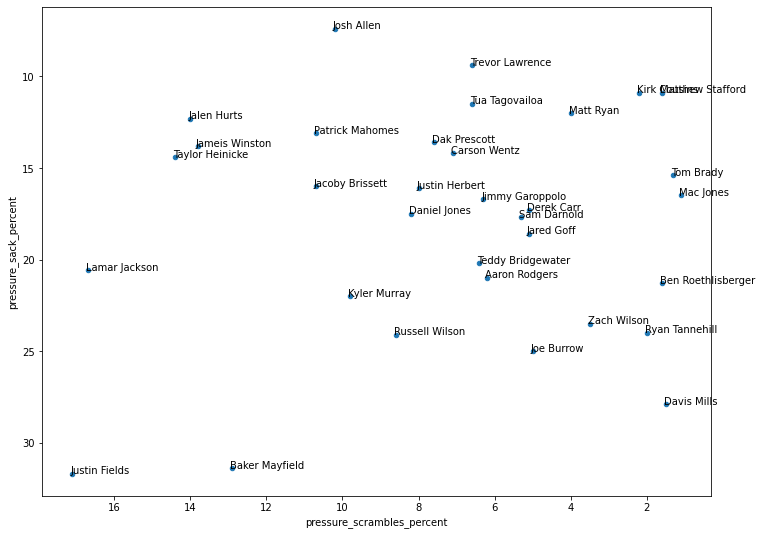

In [56]:
#Look At The Top 34 Quarterbacks By Total Snaps Taken During Weeks 1-8 During The 2021 Season
plt.rcParams["figure.figsize"] = [12, 9]

ax = pff_qb_pressure.plot.scatter(x = 'pressure_scrambles_percent', y = 'pressure_sack_percent')
ax.invert_xaxis()
ax.invert_yaxis()

for i, txt in enumerate(pff_qb_pressure.player):
   ax.annotate(txt, (pff_qb_pressure.pressure_scrambles_percent.iat[i]+0.05, pff_qb_pressure.pressure_sack_percent.iat[i]))

In [38]:
#Import Stats Pressure Stats 
pff_qb_pressure_wks_1_4 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/passing_pressure_wks_1-4.csv") #Import PFF Data On QB Pressures
pff_qb_pressure_wks_5_8 = pd.read_csv("C:/Users/Peter/Python Scripts/Case Competitions/NFL Big Data Bowl 2023/merged_data/passing_pressure_wks_5-8.csv") #Import PFF Data On QB Pressures

#Merge And See Which Stablizes Faster
pff_qb_pressure_wks_c = pff_qb_pressure_wks_1_4.merge(pff_qb_pressure_wks_5_8, on = ['player', 'player_id', 'team_name'], how = 'inner')

#Minimum 30 Pressure Dropbacks For Each Segment
pff_qb_pressure_wks_c_30_db = pff_qb_pressure_wks_c.loc[(pff_qb_pressure_wks_c.pressure_dropbacks_14 >= 30) & (pff_qb_pressure_wks_c.pressure_dropbacks_58 >= 30)]

In [49]:
#Correlation Between Pressure Scramble Percent in Weeks 1-4 vs Weeks 5-8
# corr, _ = spearmanr(pff_qb_pressure_wks_c_30_db.pressure_scrambles_percent_14.astype(float), pff_qb_pressure_wks_c_30_db.pressure_scrambles_percent_58.astype(float))

#Correlation Between Pressure Sack Percent in Weeks 1-4 vs Weeks 5-8
corr, _ = spearmanr(pff_qb_pressure_wks_c_30_db.pressure_sack_percent_14.astype(float), pff_qb_pressure_wks_c_30_db.pressure_sack_percent_58.astype(float))
print(corr)

#Pressure Sack Percent Seems To Normalize Quicker Over A 8 Week Sample (.544 Spearman R vs .521 Spearman R)
#QB Can Scramble But Still Get Sacked, But With Sack Avoidance The QB Can Be In The Pocket And The Rusher Still Has A Shot of Reaching Them

0.5440927077444884


<font size="5"> Explore Speed and Acceleration of The Pass Rusher Coming Into The Immediate Zone </font>

In [119]:
#Create Data Frame With Only Pass Blocking Plays and Where The Player Rusher Is Known And Is A Pass Rusher 
#These Are All The Columns For Which The Immediate Zone Was Calculated And Where The QB Has Possession of The Football
ptrack_qb_poss_block = ptrack_qb_poss.loc[(ptrack_qb_poss['pff_blockType'] != '0') & (ptrack_qb_poss['pff_nflIdBlockedPlayer'] == ptrack_qb_poss['nflId_rusher'])]

#Create Composite PK of gameId, playId, and nflId 
ptrack_qb_poss_block[['gameId', 'playId', 'nflId']] = ptrack_qb_poss_block[['gameId', 'playId', 'nflId']].astype(str)
ptrack_qb_poss_block['game_play_nfl_Id'] = ptrack_qb_poss_block[["gameId", "playId", 'nflId']].apply("-".join, axis=1)

#These Are All The Columns For Which The Immediate Zone Was Calculated And Where The QB Has Possession of The Football

C:\Users\Peter\AppData\Local\Temp\ipykernel_12960\3283763428.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Peter\AppData\Local\Temp\ipykernel_12960\3283763428.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#Percent of Time That Pass Rusher Is Already In Zone On First Frame Of Play (No Frame To Measure Speed/Acceleration)
position_no_speed = ptrack_qb_poss_block.loc[(ptrack_qb_poss_block.frameId == ptrack_qb_poss_block.frame_first) & (ptrack_qb_poss_block.pff_positionLinedUp == "C")]['rusher_in_imm_box'].value_counts()[1]
position_no_speed/ptrack_qb_poss_block.loc[(ptrack_qb_poss_block.frameId == ptrack_qb_poss_block.frame_first)  & (ptrack_qb_poss_block.pff_positionLinedUp == "C")].shape[0]

#Measuring 1 Frame Before Rusher Enters The Immediate Zone Means ~15% of The Time We Won't Have Access To Rusher Speed

#- Rates of No Rusher Data Prior To Immediate Zone

#    - Centers = 20.5%
#    - Left Guards = 21.6% 
#    - Right Guards = 18.8%
#    - Left Tackle = 7.8%
#    - Right Tackle = 11.1%

#Becuase Of This, Use Speed In First Frame In The Immediate Zone On A Play

In [ ]:
#What Is The X Percentile Minimum Distance That A Pass Rusher Ever Gets From A Blocker
ptrack_qb_poss_block.groupby(['gameId', 'playId', 'nflId'])['blocker_rusher_distance'].min().quantile([.9, .95, .97, .98,.99, 1])

#98th Percentile For Minimum Distance When Blocks Occur Is 1.52 Yards, So Depth Should Be About That Much

In [ ]:
#Look At Occurances Where The Minimum Distance Is More Than 1.68 Yards (Maximum Distance At .75 X 1.5 Yards Immediate Zone Blocker From Rusher)
ptrack_min_rusher_blocker_dist = ptrack_qb_poss_block.groupby(['gameId', 'playId', 'nflId'])['blocker_rusher_distance'].min().reset_index()
ptrack_min_rusher_blocker_dist.loc[ptrack_min_rusher_blocker_dist.blocker_rusher_distance >= 1.68].shape

#Since There Are Only 570 Instances Out of 47904 (or 1.1%), We Should Consider Removing All Instances Where Minimum Distance Is More Than 1.68 Yards

In [124]:
#Count the Number of Plays That Don't Have The Rusher Enter The Immediate Zone
count_no_imm_box = pd.DataFrame(ptrack_qb_poss_block.groupby('game_play_nfl_Id')['rusher_in_imm_box'].value_counts())
count_no_imm_box = count_no_imm_box.rename(columns = {'rusher_in_imm_box': 'count'})
count_no_imm_box = count_no_imm_box.reset_index()

#Percentage of Rushers Never In The Immediate Zone On A Play
count_no_imm_box[count_no_imm_box.groupby('game_play_nfl_Id')['game_play_nfl_Id'].transform('size') < 2].loc[count_no_imm_box['rusher_in_imm_box'] == False].shape[0]/ptrack_qb_poss_block.game_play_nfl_Id.drop_duplicates().shape[0]

# #Examine The Data
# no_imm_box = count_no_imm_box[count_no_imm_box.groupby('game_play_nfl_Id')['game_play_nfl_Id'].transform('size') < 2].loc[count_no_imm_box['rusher_in_imm_box'] == False]
# no_imm_box = ptrack_qb_poss_block.merge(no_imm_box, on = 'game_play_nfl_Id', how = 'inner')

#Number of Rushers That Never Even Enter The Immediate Zone: 11,428 Out of The 46,096

0.0336912897277362

In [125]:
#Examine The Data
no_imm_box = count_no_imm_box[count_no_imm_box.groupby('game_play_nfl_Id')['game_play_nfl_Id'].transform('size') < 2].loc[count_no_imm_box['rusher_in_imm_box'] == False]
no_imm_box = ptrack_qb_poss_block.merge(no_imm_box, on = 'game_play_nfl_Id', how = 'inner')

#Number of Rushers That Never Even Enter The Immediate Zone: 3,521 Out of The 46,096
count_no_imm_box[count_no_imm_box.groupby('game_play_nfl_Id')['game_play_nfl_Id'].transform('size') < 2].loc[count_no_imm_box['rusher_in_imm_box'] == False]

,game_play_nfl_Id,rusher_in_imm_box,count
29,2021090900-1267-42377,0.0,32
103,2021090900-1563-47873,0.0,28
118,2021090900-1687-37082,0.0,33
143,2021090900-1776-46119,0.0,30
146,2021090900-1776-47873,0.0,30
...,...,...,...
89040,2021110100-3831-43695,0.0,30
89068,2021110100-3909-47959,0.0,39
89069,2021110100-3909-52507,0.0,39
89078,2021110100-393-53655,0.0,61


In [44]:
#Understand How The Immediate Zone Needs To Be Expanded, Since 3% of Rushers Are Not Entering The Immediate Zone

#Compare Distances To Rest of Data
# no_imm_box.blocker_rusher_distance.median()
# ptrack_qb_poss_block.blocker_rusher_distance.median()

#Compare Direction To Rest of Data
# no_imm_box.diff_btw_rusher_dir_blocker_o.median()
# ptrack_qb_poss_block.diff_btw_rusher_dir_blocker_o.median()

#When Rushers Aren't Being Registered, It Seems That They're Not Running Directly Into The Blocker (Solution: Widen The Zone)

186.11

<font size="5"> Look At Specific Plays With The Immediate Zone Vizualized  </font>

In [130]:
#Check If Specific Play Is In The Immediate Zone
test = ptrack.loc[(ptrack['gameId'] == 2021103111) & (ptrack['nflId'] == 52421) & (ptrack['playId'] == 1063)].sort_values(by = 'frameId', ascending = True)[20:21]
test

,Unnamed: 0,gameId,playId,nflId,pff_role,pff_positionLinedUp,pff_hit,pff_hurry,pff_sack,pff_beatenByDefender,pff_hitAllowed,pff_hurryAllowed,pff_sackAllowed,pff_nflIdBlockedPlayer,pff_blockType,pff_backFieldBlock,frameId,time,jerseyNumber,team,playDirection,x,y,s,a,dis,o,dir,event,height,weight,birthDate,collegeName,officialPosition,displayName,x_qb,y_qb,s_qb,a_qb,dis_qb,o_qb,dir_qb,dist_from_qb,angle_to_qb,angle_to_qb_diff_o,nflId_blocker,nflId_rusher,displayName_rusher,pff_positionLinedUp_rusher,x_rusher,y_rusher,s_rusher,a_rusher,dis_rusher,o_rusher,dir_rusher,rusher_in_imm_box,blocker_rusher_distance,diff_btw_rusher_dir_blocker_o
235869,235869,2021103111,1063,52421,Pass Block,RT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37097.0,PA,0.0,21,2021-10-31T21:05:47.000,78.0,TB,left,56.43,28.02,2.21,1.18,0.23,324.77,76.61,None,6-5,322,1999-01-24,Iowa,T,Tristan Wirfs,59.46,24.09,4.86,0.69,0.49,1.42,86.73,4.962439,30.73,294.04,52421.0,37097.0,Cameron Jordan,LOLB,56.0,28.89,3.04,0.33,0.33,138.54,79.4,1.0,0.97,425.37


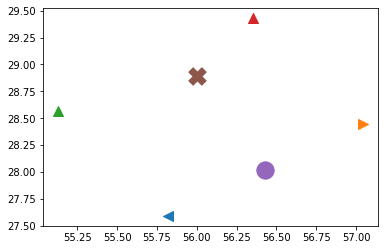

In [109]:
#Plot The Immediate Zone On The Above Play
plt.scatter(x = test.bl_im_x_x, y = test.bl_im_y_x, s = 100, marker = '<')
plt.scatter(x = test.br_im_x_x, y = test.br_im_y_x, s = 100, marker = '>')
plt.scatter(x = test.fl_im_x_x, y = test.fl_im_y_x, s = 100, marker = '^')
plt.scatter(x = test.fr_im_x_x, y = test.fr_im_y_x, s = 100, marker = '^')
plt.scatter(x = test.x, y = test.y, s = 300, marker = 'o')
plt.scatter(x = test.x_rusher_x, y = test.y_rusher_x, s = 300, marker = 'X')